In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import warnings; warnings.simplefilter('ignore')
import sys
sys.path.insert(0, '/Users/jsmonzon/Research/SatGen/mcmc/src/')
import jsm_halopull
import jsm_SHMR
import jsm_mcmc
import jsm_stats
import jsm_models
import seaborn as sns

In [3]:
plt.style.use('../paper/paper.mplstyle')
double_textwidth = 7.0 #inches
single_textwidth = 3.5 #inches

In [4]:
# s0_full = jsm_halopull.MassMat("../../../data/MW-analog/meta_data_psi3/", save=True, plot=False, phi_res=-4, Nsamp=100)
# s15_full = jsm_halopull.MassMat("../../../data/cross_host/lognorm_015_psi3/", save=True, plot=False, phi_res=-4, Nsamp=100)
# s30_full = jsm_halopull.MassMat("../../../data/cross_host/lognorm_030_psi3/", save=True, plot=False, phi_res=-4, Nsamp=100)

### calling in 10k merger tree realizations

In [5]:
s0_mat = np.load("../../../data/MW-analog/meta_data_psi3/models.npz")
s15_mat = np.load("../../../data/cross_host/lognorm_015_psi3/models.npz")
s30_mat = np.load("../../../data/cross_host/lognorm_030_psi3/models.npz")

In [6]:
class Fid_Real:

    def __init__(self, models, red_cut, **kwargs):

        self.hosts = np.log10(np.concatenate(models["host_mass"], axis=0))
        self.z50s = np.concatenate(models["z50"], axis=0)
        self.subs = np.concatenate(models["mass"], axis=0)

        self.mask = self.z50s < red_cut
        self.late_ind = np.where(self.mask)[0]
        self.early_ind = np.where(~self.mask)[0]

        self.late_SAGAs = np.random.choice(self.late_ind, size=(int(self.late_ind.shape[0]/100), 100), replace=False)
        self.early_SAGAs = np.random.choice(self.early_ind, size=(int(self.early_ind.shape[0]/100), 100), replace=False)

        self.fid_theta = [10.5, 2.0, 0.0, 0, 0, 0] # no scatter in the SHMR!
        self.min_mass = 6.5

    def push_full(self):

        self.lgMs = jsm_SHMR.general_old(self.fid_theta, self.subs, 0, 1)
        self.stat = jsm_stats.SatStats_D( self.lgMs, min_mass=self.min_mass, max_N=500)

    def push_late_SAGA(self):


        N_std = []
        Ms1_std = []
        print("This epoch only has", self.late_SAGAs.shape[0], "realizations")
        for i in self.late_SAGAs:
            lgMs_i = jsm_SHMR.general_old(self.fid_theta, self.subs[i], 0, 1)
            stat_i = jsm_stats.SatStats_D(lgMs_i, min_mass=self.min_mass, max_N=500)
            N_std.append(np.mean(stat_i.Nsat_perhost))
            Ms1_std.append(np.log10(np.mean(10**stat_i.maxmass)))

        self.late_N_stds = np.array(N_std)
        self.late_Ms1_stds = np.array(Ms1_std)

    def push_early_SAGA(self):


        N_std = []
        Ms1_std = []
        print("This epoch only has", self.early_SAGAs.shape[0], "realizations")
        for i in self.early_SAGAs:
            lgMs_i = jsm_SHMR.general_old(self.fid_theta, self.subs[i], 0, 1)
            stat_i = jsm_stats.SatStats_D(lgMs_i, min_mass=self.min_mass, max_N=500)
            N_std.append(np.mean(stat_i.Nsat_perhost))
            Ms1_std.append(np.log10(np.mean(10**stat_i.maxmass)))

        self.early_N_stds = np.array(N_std)
        self.early_Ms1_stds = np.array(Ms1_std)

In [7]:
red_cut = 1.2
bins = np.linspace(-0.5, 3.5, 20)

s0_models = Fid_Real(s0_mat, red_cut)
s15_models = Fid_Real(s15_mat, red_cut)
s30_models = Fid_Real(s30_mat, red_cut)

In [8]:
s0_models.push_full()
s15_models.push_full()
s30_models.push_full()

In [9]:
global_zmin = min(s0_models.z50s.min(), s15_models.z50s.min(), s30_models.z50s.min())
global_zmax = max(s0_models.z50s.max(), s15_models.z50s.max(), s30_models.z50s.max())

# Create a Normalize object with the global min and max
znorm = Normalize(vmin=global_zmin, vmax=2.5)

z_acc_norm = Normalize(vmin=global_zmin, vmax=1.5)

hnorm = Normalize(vmin=11.5, vmax=12.5)

In [10]:
zacc_S0 = np.concatenate(s0_mat["redshift"], axis=0)[s0_models.stat.nan_mask]
macc_S0 = jsm_SHMR.general_old([10.5, 2.0, 0.0, 0, 0, 0], np.concatenate(s0_mat["mass"], axis=0)[s0_models.stat.nan_mask], 0, 1)

zacc_S0_list = []

for i in range(zacc_S0.shape[0]):
    ind = np.where(macc_S0[i] == s0_models.stat.mass_rank[:,0][i])[0]
    zacc_S0_list.append(zacc_S0[i][ind][0])

In [11]:
zacc_S15 = np.concatenate(s15_mat["redshift"], axis=0)[s15_models.stat.nan_mask]
macc_S15 = jsm_SHMR.general_old([10.5, 2.0, 0.0, 0, 0, 0], np.concatenate(s15_mat["mass"], axis=0)[s15_models.stat.nan_mask], 0, 1)

zacc_S15_list = []

for i in range(zacc_S15.shape[0]):
    ind = np.where(macc_S15[i] == s15_models.stat.mass_rank[:,0][i])[0]
    zacc_S15_list.append(zacc_S15[i][ind][0])

In [12]:
zacc_S30 = np.concatenate(s30_mat["redshift"], axis=0)[s30_models.stat.nan_mask]
macc_S30 = jsm_SHMR.general_old([10.5, 2.0, 0.0, 0, 0, 0], np.concatenate(s30_mat["mass"], axis=0)[s30_models.stat.nan_mask], 0, 1)

zacc_S30_list = []

for i in range(zacc_S30.shape[0]):
    ind = np.where(macc_S30[i] == s30_models.stat.mass_rank[:,0][i])[0]
    zacc_S30_list.append(zacc_S30[i][ind][0])

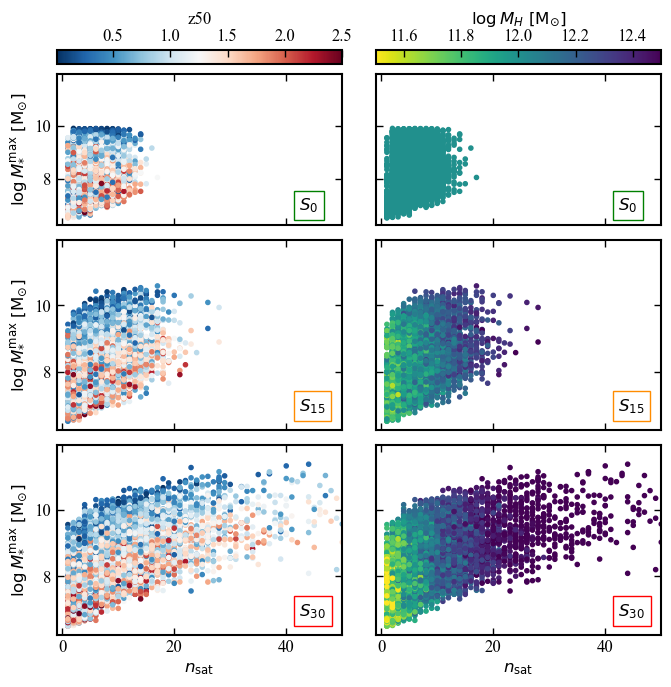

In [13]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(double_textwidth,double_textwidth))

axs[0,0].scatter(s0_models.stat.Nsat_perhost, s0_models.stat.maxmass, marker=".", c=s0_models.z50s[s0_models.stat.nan_mask], norm=znorm, cmap="RdBu_r", rasterized=True)
axs[1,0].scatter(s15_models.stat.Nsat_perhost, s15_models.stat.maxmass, marker=".", c=s15_models.z50s[s15_models.stat.nan_mask], norm=znorm, cmap="RdBu_r", rasterized=True)
axs[2,0].scatter(s30_models.stat.Nsat_perhost, s30_models.stat.maxmass, marker=".", c=s30_models.z50s[s30_models.stat.nan_mask], norm=znorm, cmap="RdBu_r", rasterized=True)
axs[0,0].set_ylabel("$\log M_{*}^{\mathrm{max}}\ [\mathrm{M}_{\odot}]$")
axs[1,0].set_ylabel("$\log M_{*}^{\mathrm{max}}\ [\mathrm{M}_{\odot}]$")
axs[2,0].set_ylabel("$\log M_{*}^{\mathrm{max}}\ [\mathrm{M}_{\odot}]$")
axs[2,0].set_xlabel("$n_{\mathrm{sat}}$")

axs[0,1].scatter(s0_models.stat.Nsat_perhost, s0_models.stat.maxmass, marker=".", c=s0_models.hosts[s0_models.stat.nan_mask], norm=hnorm, cmap="viridis_r", rasterized=False)
axs[1,1].scatter(s15_models.stat.Nsat_perhost, s15_models.stat.maxmass, marker=".", c=s15_models.hosts[s15_models.stat.nan_mask], norm=hnorm, cmap="viridis_r", rasterized=True)
axs[2,1].scatter(s30_models.stat.Nsat_perhost, s30_models.stat.maxmass, marker=".", c=s30_models.hosts[s30_models.stat.nan_mask], norm=hnorm, cmap="viridis_r", rasterized=True)
axs[2,1].set_xlabel("$n_{\mathrm{sat}}$")
axs[2,1].set_xlim(-1, 50)


# Add colorbars on top of each column
cbar1 = fig.colorbar(ScalarMappable(norm=znorm, cmap='RdBu_r'), ax=axs[0, 0], orientation='horizontal', location='top')
cbar1.set_label("z50")

cbar2 = fig.colorbar(ScalarMappable(norm=hnorm, cmap='viridis_r'), ax=axs[0, 1], orientation='horizontal', location='top')
cbar2.set_label("$\log M_{H}\ [\mathrm{M}_{\odot}]$")


axs[0,0].text(0.85, 0.1, "$S_0$", transform=axs[0,0].transAxes, fontsize=12, fontweight='bold', bbox=dict(facecolor='white', alpha=1, edgecolor="green"))
axs[1,0].text(0.85, 0.1, "$S_{15}$", transform=axs[1,0].transAxes, fontsize=12, fontweight='bold', bbox=dict(facecolor='white', alpha=1, edgecolor="darkorange"))
axs[2,0].text(0.85, 0.1, "$S_{30}$", transform=axs[2,0].transAxes, fontsize=12, fontweight='bold', bbox=dict(facecolor='white', alpha=1, edgecolor="red"))

axs[0,1].text(0.85, 0.1, "$S_0$", transform=axs[0,1].transAxes, fontsize=12, fontweight='bold', bbox=dict(facecolor='white', alpha=1, edgecolor="green"))
axs[1,1].text(0.85, 0.1, "$S_{15}$", transform=axs[1,1].transAxes, fontsize=12, fontweight='bold', bbox=dict(facecolor='white', alpha=1, edgecolor="darkorange"))
axs[2,1].text(0.85, 0.1, "$S_{30}$", transform=axs[2,1].transAxes, fontsize=12, fontweight='bold', bbox=dict(facecolor='white', alpha=1, edgecolor="red"))

plt.tight_layout()
#plt.savefig("../../../paper_1/figures/aux/MAHs.pdf", bbox_inches="tight")
plt.show()

In [14]:
# r0_12 = jsm_stats.correlation(s0_models.stat.maxmass[~np.isnan(s0_models.stat.secmass)], s0_models.stat.secmass[~np.isnan(s0_models.stat.secmass)])
# r15_12 = jsm_stats.correlation(s15_models.stat.maxmass[~np.isnan(s15_models.stat.secmass)], s15_models.stat.secmass[~np.isnan(s15_models.stat.secmass)])
# r30_12 = jsm_stats.correlation(s30_models.stat.maxmass[~np.isnan(s30_models.stat.secmass)], s30_models.stat.secmass[~np.isnan(s30_models.stat.secmass)])

# r0_23 = jsm_stats.correlation(s0_models.stat.secmass[~np.isnan(s0_models.stat.thirmass)], s0_models.stat.thirmass[~np.isnan(s0_models.stat.thirmass)])
# r15_23 = jsm_stats.correlation(s15_models.stat.secmass[~np.isnan(s15_models.stat.thirmass)], s15_models.stat.thirmass[~np.isnan(s15_models.stat.thirmass)])
# r30_23 = jsm_stats.correlation(s30_models.stat.secmass[~np.isnan(s30_models.stat.thirmass)], s30_models.stat.thirmass[~np.isnan(s30_models.stat.thirmass)])

In [15]:
n = 6

In [16]:
r0_12 = jsm_stats.correlation(s0_models.stat.max_split[n], s0_models.stat.sec_split[n])
r15_12 = jsm_stats.correlation(s15_models.stat.max_split[n], s15_models.stat.sec_split[n])
r30_12 = jsm_stats.correlation(s30_models.stat.max_split[n], s30_models.stat.sec_split[n])

In [17]:
r0_23 = jsm_stats.correlation(s0_models.stat.thir_split[n], s0_models.stat.sec_split[n])
r15_23 = jsm_stats.correlation(s15_models.stat.thir_split[n], s15_models.stat.sec_split[n])
r30_23 = jsm_stats.correlation(s30_models.stat.thir_split[n], s30_models.stat.sec_split[n])

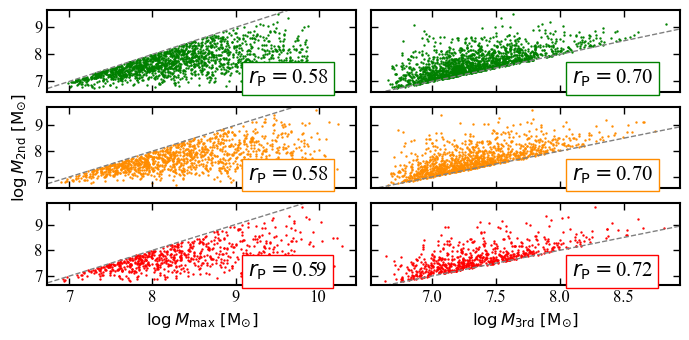

In [18]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex="col", sharey="row", figsize=(double_textwidth,single_textwidth))

axs[0,0].scatter(s0_models.stat.max_split[n], s0_models.stat.sec_split[n], marker=".", s=2, color="green")
axs[1,0].scatter(s15_models.stat.max_split[n], s15_models.stat.sec_split[n], marker=".", s=2, color="darkorange")
axs[2,0].scatter(s30_models.stat.max_split[n], s30_models.stat.sec_split[n], marker=".", s=2, color="red")

#axs[0,0].set_ylabel("$\log M_{\mathrm{2nd}}\ [\mathrm{M}_{\odot}]$")
axs[1,0].set_ylabel("$\log M_{\mathrm{2nd}}\ [\mathrm{M}_{\odot}]$")
#axs[2,0].set_ylabel("$\log M_{\mathrm{2nd}}\ [\mathrm{M}_{\odot}]$")

axs[2,0].set_xlabel("$\log M_{\mathrm{max}}\ [\mathrm{M}_{\odot}]$")

axs[0,1].scatter(s0_models.stat.thir_split[n], s0_models.stat.sec_split[n], marker=".", s=2, color="green")
axs[1,1].scatter(s15_models.stat.thir_split[n], s15_models.stat.sec_split[n], marker=".", s=2, color="darkorange")
axs[2,1].scatter(s30_models.stat.thir_split[n], s30_models.stat.sec_split[n], marker=".", s=2, color="red")

# axs[0,1].set_ylabel("$\log M_{\mathrm{3rd}}\ [\mathrm{M}_{\odot}]$")
# axs[1,1].set_ylabel("$\log M_{\mathrm{3rd}}\ [\mathrm{M}_{\odot}]$")
# axs[2,1].set_ylabel("$\log M_{\mathrm{3rd}}\ [\mathrm{M}_{\odot}]$")

axs[2,1].set_xlabel("$\log M_{\mathrm{3rd}}\ [\mathrm{M}_{\odot}]$")

for ax in axs.flatten():
    xpoints = ax.get_xlim()
    ax.plot(xpoints, xpoints, linestyle='--', color='grey', lw=1, scalex=False, scaley=False)


axs[0,0].text(0.65, 0.1, "$r_{\mathrm{P}} =$"+f"{r0_12:.2f}", transform=axs[0,0].transAxes, fontsize=15, bbox=dict(facecolor='white', alpha=1, edgecolor="green"))
axs[1,0].text(0.65, 0.1, "$r_{\mathrm{P}} =$"+f"{r15_12:.2f}", transform=axs[1,0].transAxes, fontsize=15, bbox=dict(facecolor='white', alpha=1, edgecolor="darkorange"))
axs[2,0].text(0.65, 0.1, "$r_{\mathrm{P}} =$"+f"{r30_12:.2f}", transform=axs[2,0].transAxes, fontsize=15, bbox=dict(facecolor='white', alpha=1, edgecolor="red"))

axs[0,1].text(0.65, 0.1, "$r_{\mathrm{P}} =$"+f"{r0_23:.2f}", transform=axs[0,1].transAxes, fontsize=15, bbox=dict(facecolor='white', alpha=1, edgecolor="green"))
axs[1,1].text(0.65, 0.1, "$r_{\mathrm{P}} =$"+f"{r15_23:.2f}", transform=axs[1,1].transAxes, fontsize=15, bbox=dict(facecolor='white', alpha=1, edgecolor="darkorange"))
axs[2,1].text(0.65, 0.1, "$r_{\mathrm{P}} =$"+f"{r30_23:.2f}", transform=axs[2,1].transAxes, fontsize=15, bbox=dict(facecolor='white', alpha=1, edgecolor="red"))

plt.tight_layout()
#plt.savefig("../../../paper_1/figures/aux/mass_rank_correlation.pdf", bbox_inches="tight")
plt.show()

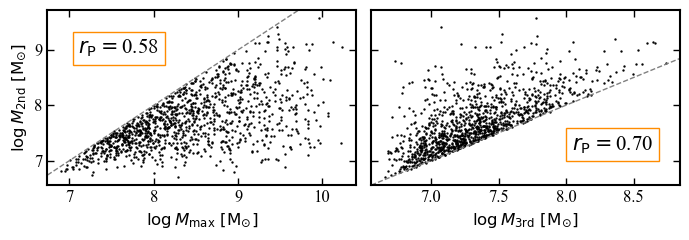

In [33]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex="col", sharey="row", figsize=(double_textwidth,2.5))

axs[0].scatter(s15_models.stat.max_split[n], s15_models.stat.sec_split[n], marker=".", s=2, color="k")

#axs[0,0].set_ylabel("$\log M_{\mathrm{2nd}}\ [\mathrm{M}_{\odot}]$")
axs[0].set_ylabel("$\log M_{\mathrm{2nd}}\ [\mathrm{M}_{\odot}]$")
#axs[2,0].set_ylabel("$\log M_{\mathrm{2nd}}\ [\mathrm{M}_{\odot}]$")

axs[0].set_xlabel("$\log M_{\mathrm{max}}\ [\mathrm{M}_{\odot}]$")

axs[1].scatter(s15_models.stat.thir_split[n], s15_models.stat.sec_split[n], marker=".", s=2, color="k")
axs[1].set_xlabel("$\log M_{\mathrm{3rd}}\ [\mathrm{M}_{\odot}]$")

for ax in axs.flatten():
    xpoints = ax.get_xlim()
    ax.plot(xpoints, xpoints, linestyle='--', color='grey', lw=1, scalex=False, scaley=False)



axs[0].text(0.1, 0.75, "$r_{\mathrm{P}} =$"+f"{r15_12:.2f}", transform=axs[0].transAxes, fontsize=15, bbox=dict(facecolor='white', alpha=1, edgecolor="darkorange"))
axs[1].text(0.65, 0.2, "$r_{\mathrm{P}} =$"+f"{r15_23:.2f}", transform=axs[1].transAxes, fontsize=15, bbox=dict(facecolor='white', alpha=1, edgecolor="darkorange"))


# axs[0,0].text(0.65, 0.1, "$r_{\mathrm{P}} =$"+f"{r15_12:.2f}", transform=axs[0,0].transAxes, fontsize=15, bbox=dict(facecolor='white', alpha=1, edgecolor="darkorange"))

# axs[0,1].text(0.65, 0.1, "$r_{\mathrm{P}} =$"+f"{r15_23:.2f}", transform=axs[0,1].transAxes, fontsize=15, bbox=dict(facecolor='white', alpha=1, edgecolor="darkorange"))

plt.tight_layout()
plt.savefig("../../../paper_1/figures/aux/mass_rank_correlation.pdf", bbox_inches="tight")
plt.show()